# Estrutura do trabalho

* ~Aplicar Cross Validation pro cálculo de MSE no Random Tree~
* ~Testar Random Forest~
* ~Testar XGBoosting~
* Adicionar PDP e ICE (só para o melhor modelo, para facilitar)
* ~Usar RandomSearch; ou tree of parzen estimator (TPE)~

Juan: Testei os modelos para os melhores hiperparâmetros (dado o espaço que definimos) e acredito que o melhor é a floresta de regressão aleatória, deu o melhor `MSE`:

`-----` | `Árvore` | `Floresta` | `XGBoost` | `Rede Neural` 

`Tinto` | `0.5322` |  `0.4237` | `0.5181` | `0.4531`

`Branco`| `0.6068` |  `0.3911` | `0.5271` | `0.5140`

Olha, talvez dê para melhorar estas métricas se mexermos mais nos hiperparâmetros de cada modelo, só que de momento não vou fazer isto, me contento com estes resultados, e estarei escrevendo os slides ou o relatório.

# Carregamento, Vizualização e Tratamento dos Dados

##Downloads

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, shapiro
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb




np.random.seed(42)

## Leitura dados

In [2]:
# Carregando os dados:
df= pd.read_csv('https://raw.githubusercontent.com/derSchmetterling/ML2022/main/winequality-red.csv', header=0)
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [3]:
round(df.describe().iloc[1:8,:], 3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


In [4]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

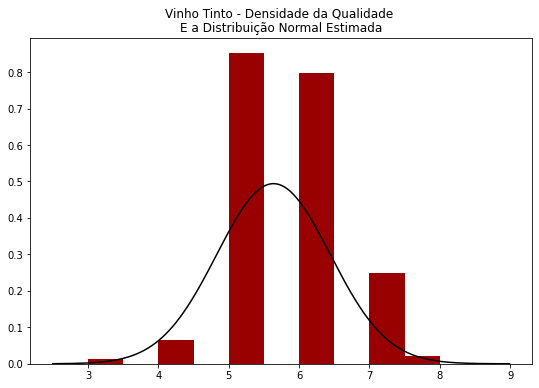

In [5]:
plt.figure(figsize=(9,6))

sup = np.arange(2.5, 9, 0.01)
mu = df['quality'].mean()
sig = df['quality'].std()
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(df['quality'], density=True, color='#990000')
plt.title('Vinho Tinto - Densidade da Qualidade \nE a Distribuição Normal Estimada')

plt.show()

In [6]:
a = shapiro(df['quality'])
if (a[1] < 0.05): print('Rejeita-se a normalidade.')
else: print('Não há evidências para rejeitar a normalidade.')

Rejeita-se a normalidade.


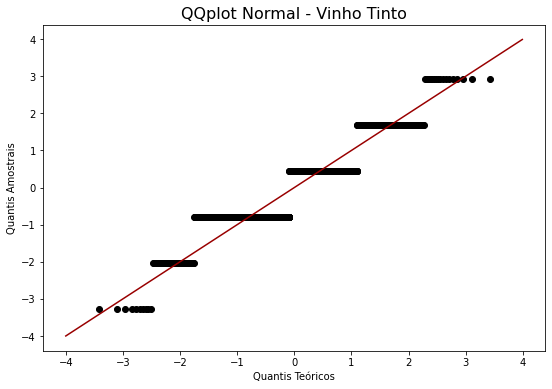

In [7]:
plt.figure(figsize=(9,6))

aux = np.sort(df['quality'])
aux = (aux-aux.mean())/aux.std()
auxB = []

for i in range(1,len(aux)+1):
  # quantis teoricos da normal
  auxB.append(norm.ppf((i-0.5)/len(aux)))

plt.scatter(auxB, aux, color='black')
plt.plot(np.arange(-4,4,0.01), np.arange(-4,4,0.01), color='#990000')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Amostrais')

plt.title('QQplot Normal - Vinho Tinto', fontsize=16)
plt.show()

In [8]:
df_white = pd.read_csv('https://raw.githubusercontent.com/derSchmetterling/ML2022/main/winequality-white.csv', header=0, sep = ';')
df_white.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


In [9]:
round(df_white.describe().iloc[1:8,:], 3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,6.855,0.278,0.334,6.391,0.046,35.308,138.361,0.994,3.188,0.490,10.514,5.878
std,0.844,0.101,0.121,5.072,0.022,17.007,42.498,0.003,0.151,0.114,1.231,0.886
min,3.800,0.080,0.000,0.600,0.009,2.000,9.000,0.987,2.720,0.220,8.000,3.000
25%,6.300,0.210,0.270,1.700,0.036,23.000,108.000,0.992,3.090,0.410,9.500,5.000
50%,6.800,0.260,0.320,5.200,0.043,34.000,134.000,0.994,3.180,0.470,10.400,6.000
75%,7.300,0.320,0.390,9.900,0.050,46.000,167.000,0.996,3.280,0.550,11.400,6.000
max,14.200,1.100,1.660,65.800,0.346,289.000,440.000,1.039,3.820,1.080,14.200,9.000


In [10]:
df_white['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

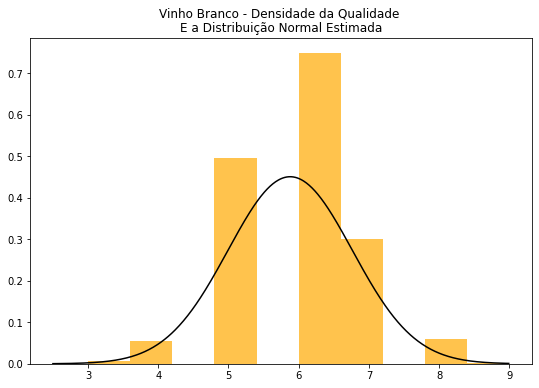

In [11]:
plt.figure(figsize=(9,6))

sup = np.arange(2.5, 9, 0.01)
mu = df_white['quality'].mean()
sig = df_white['quality'].std()
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(df_white['quality'], density=True, color='#ffc34d')
plt.title('Vinho Branco - Densidade da Qualidade \nE a Distribuição Normal Estimada')

plt.show()

In [12]:
a = shapiro(df_white['quality'])
if (a[1] < 0.05): print('Rejeita-se a normalidade.')
else: print('Não há evidências para rejeitar a normalidade.')

Rejeita-se a normalidade.


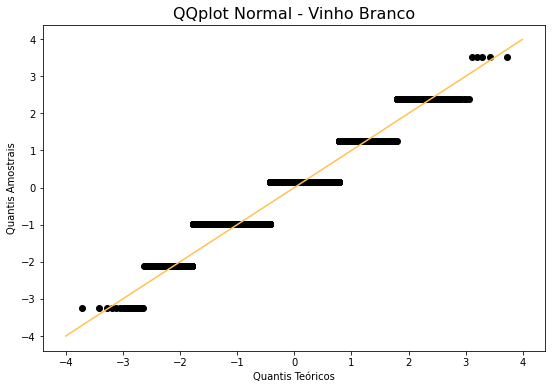

In [13]:
plt.figure(figsize=(9,6))

aux = np.sort(df_white['quality'])
aux = (aux-aux.mean())/aux.std()
auxB = []

for i in range(1,len(aux)+1):
  # quantis teoricos da normal
  auxB.append(norm.ppf((i-0.5)/len(aux)))

plt.scatter(auxB, aux, color='black')
plt.plot(np.arange(-4,4,0.01), np.arange(-4,4,0.01), color='#ffc34d')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Amostrais')

plt.title('QQplot Normal - Vinho Branco', fontsize=16)
plt.show()

## Pre-processamento dos Dados

### Vinho Tinto

In [14]:
# Tratamento log
df_trat = df.copy()

log_scale = ['residual sugar', 'chlorides', 'sulphates',
             'total sulfur dioxide', 'free sulfur dioxide',
             'volatile acidity', 'fixed acidity', 'density']

for l in log_scale:
  df_trat[l] = np.log(df_trat[l])
  df_trat.rename(columns={l: 'log '+l}, inplace=True)

# Tratamento Media 0 e Var 1
for c in df_trat.columns[:-1]:
  df_trat[c] = ( df_trat[c] - df_trat[c].mean() )/df_trat[c].std()

df_trat.head(3)

,log fixed acidity,log volatile acidity,citric acid,log residual sugar,log chlorides,log free sulfur dioxide,log total sulfur dioxide,log density,pH,log sulphates,alcohol,quality
0,-0.485156,0.966521,-1.391037,-0.582968,-0.218695,-0.216312,-0.105418,0.558786,1.288240,-0.601874,-0.959946,5
1,-0.221161,1.613546,-1.391037,0.294535,0.558268,0.981690,0.856219,0.029199,-0.719708,0.266575,-0.584594,5
2,-0.221161,1.199040,-1.185699,-0.048463,0.365188,0.236276,0.550420,0.135159,-0.331073,0.064754,-0.584594,5


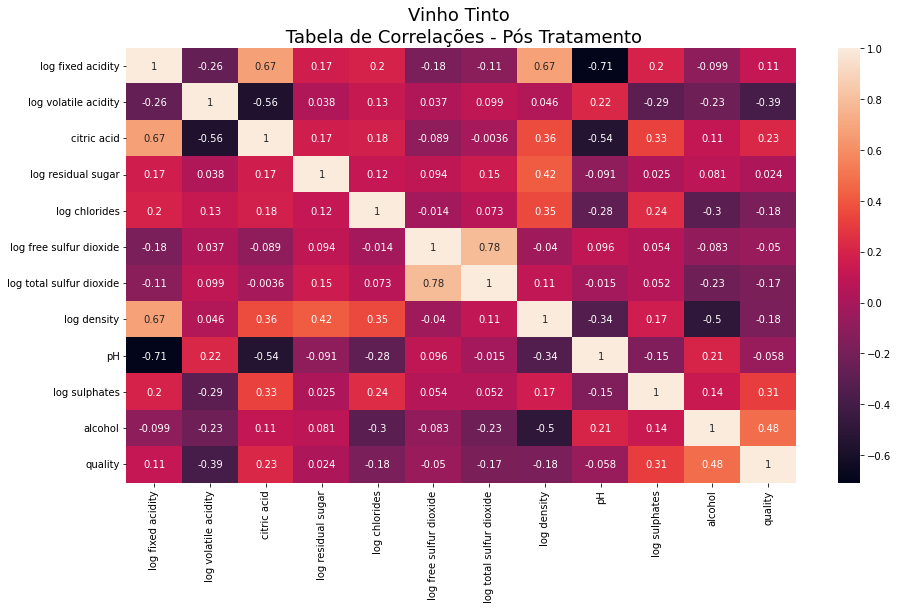

In [15]:
plt.figure(figsize = (15,8))
sns.heatmap(df_trat.corr(), annot=True)
plt.plot()
plt.title('Vinho Tinto \n Tabela de Correlações - Pós Tratamento',
          fontsize = 18)
plt.show()

In [16]:
print(df_trat.var())
print(df_trat.mean())

log fixed acidity           1.000000
log volatile acidity        1.000000
citric acid                 1.000000
log residual sugar          1.000000
log chlorides               1.000000
log free sulfur dioxide     1.000000
log total sulfur dioxide    1.000000
log density                 1.000000
pH                          1.000000
log sulphates               1.000000
alcohol                     1.000000
quality                     0.652168
dtype: float64
log fixed acidity          -4.088176e-16
log volatile acidity        1.466411e-16
citric acid                -1.066481e-16
log residual sugar          3.199442e-16
log chlorides               5.154656e-16
log free sulfur dioxide     4.976910e-16
log total sulfur dioxide   -1.777468e-16
log density                -3.554936e-17
pH                          2.861723e-15
log sulphates              -7.998605e-17
alcohol                     7.109871e-17
quality                     5.636023e+00
dtype: float64


### Vinho Branco

In [17]:
# Tratamento log
df_trat_white = df_white.copy()

for l in log_scale:
  df_trat_white[l] = np.log(df_trat_white[l])
  df_trat_white.rename(columns={l: 'log '+l}, inplace=True)

# Tratamento Media 0 e Var 1
for c in df_trat_white.columns[:-1]:
  df_trat_white[c] -= df_trat_white[c].mean()
  df_trat_white[c] /= df_trat_white[c].std()

df_trat_white.head(3)

,log fixed acidity,log volatile acidity,citric acid,log residual sugar,log chlorides,log free sulfur dioxide,log total sulfur dioxide,log density,pH,log sulphates,alcohol,quality
0,0.233483,0.083515,0.213258,1.680731,0.144667,0.679067,0.766246,2.327946,-1.246794,-0.265243,-1.393010,6
1,-0.633293,0.395086,0.047996,-1.096750,0.401763,-1.453422,0.013543,-0.007663,0.739953,0.115279,-0.824192,6
2,1.434211,0.191061,0.543783,0.488848,0.462756,-0.061466,-0.903074,0.360448,0.475053,-0.365662,-0.336633,6


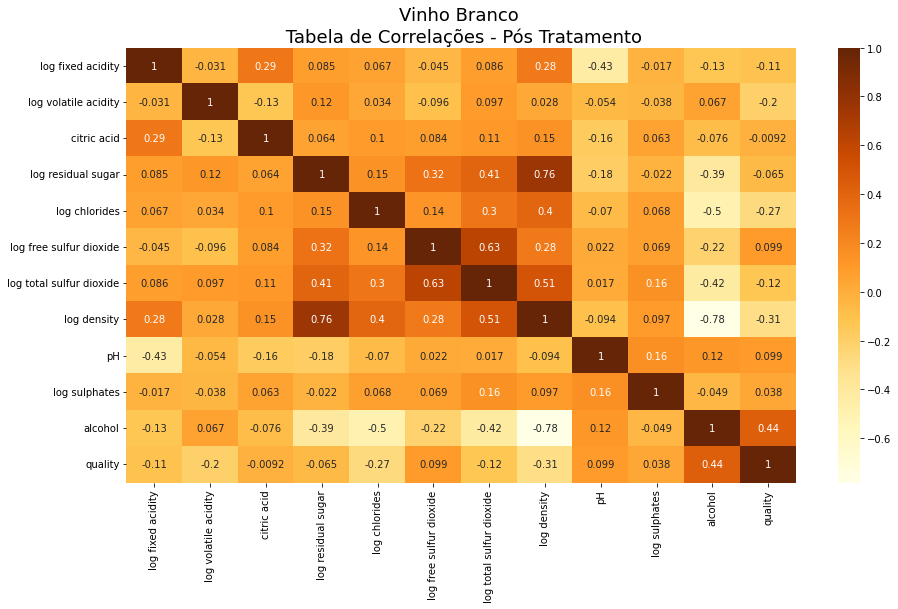

In [18]:
plt.figure(figsize = (15,8))
sns.heatmap(df_trat_white.corr(), annot=True, cmap="YlOrBr")
plt.plot()
plt.title('Vinho Branco \n Tabela de Correlações - Pós Tratamento',
          fontsize = 18)
plt.show()

In [19]:
print(df_trat_white.var())
print(df_trat_white.mean())

log fixed acidity           1.000000
log volatile acidity        1.000000
citric acid                 1.000000
log residual sugar          1.000000
log chlorides               1.000000
log free sulfur dioxide     1.000000
log total sulfur dioxide    1.000000
log density                 1.000000
pH                          1.000000
log sulphates               1.000000
alcohol                     1.000000
quality                     0.784356
dtype: float64
log fixed acidity           2.669250e-15
log volatile acidity       -2.364607e-16
citric acid                 2.321087e-17
log residual sugar         -3.191495e-17
log chlorides               5.338500e-16
log free sulfur dioxide     4.478972e-16
log total sulfur dioxide   -4.410065e-16
log density                -1.392652e-16
pH                         -1.195360e-15
log sulphates               1.646521e-16
alcohol                    -3.713739e-16
quality                     5.877909e+00
dtype: float64


## Teste e Treino

In [20]:
# Retirando parte dos dados para comparação dos modelos:

Y = df_trat['quality'].to_numpy()
X = df_trat.drop('quality', axis=1)

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,Y, test_size=479,
                                            random_state=42, shuffle=False)

print(f'Shape X_treino: {X_treino.shape}, \tShape Y_treino: {Y_treino.shape}')
print(f'Shape X_teste: {X_teste.shape}, \tShape Y_teste: {Y_teste.shape}')

Shape X_treino: (1120, 11), 	Shape Y_treino: (1120,)
Shape X_teste: (479, 11), 	Shape Y_teste: (479,)


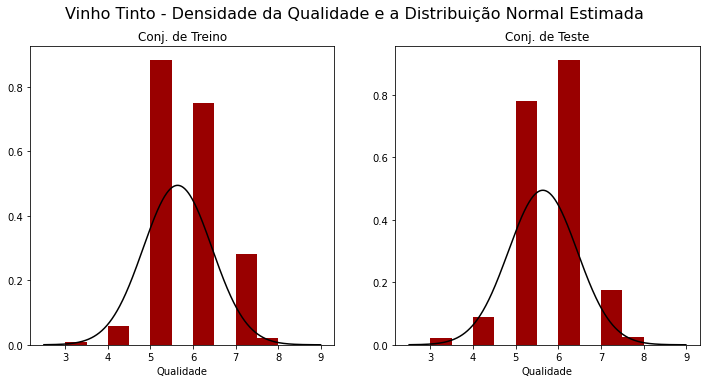

In [21]:
plt.figure(figsize=(12,5.5))

sup = np.arange(2.5, 9, 0.01)
mu = df['quality'].mean()
sig = df['quality'].std()

plt.subplot(121)
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(Y_treino, color='#990000', density=True)
plt.xlabel('Qualidade')
plt.title('Conj. de Treino')

plt.subplot(122)
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(Y_teste, color='#990000', density=True)
plt.xlabel('Qualidade')
plt.title('Conj. de Teste')

plt.suptitle('Vinho Tinto - Densidade da Qualidade e a Distribuição Normal Estimada',
             fontsize=16)
plt.show()

In [22]:
# Retirando parte dos dados para comparação dos modelos:

Y = df_trat_white['quality'].to_numpy()
X = df_trat_white.drop('quality', axis=1)

X_treino_w, X_teste_w, Y_treino_w, Y_teste_w = train_test_split(X, Y, test_size=0.3,
                                            random_state=42, shuffle=False)

print(f'Shape X_treino: {X_treino_w.shape}, \tShape Y_treino: {Y_treino_w.shape}')
print(f'Shape X_teste: {X_teste_w.shape}, \tShape Y_teste: {Y_teste_w.shape}')

Shape X_treino: (3428, 11), 	Shape Y_treino: (3428,)
Shape X_teste: (1470, 11), 	Shape Y_teste: (1470,)


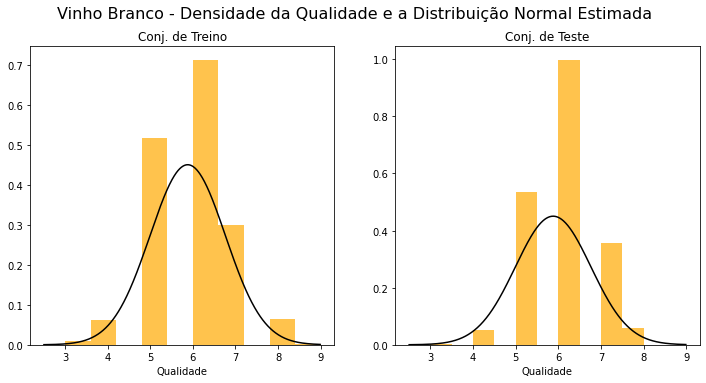

In [23]:
plt.figure(figsize=(12,5.5))

sup = np.arange(2.5, 9, 0.01)
mu = df_white['quality'].mean()
sig = df_white['quality'].std()

plt.subplot(121)
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(Y_treino_w, color='#ffc34d', density=True)
plt.xticks(np.arange(3,10))
plt.xlabel('Qualidade')
plt.title('Conj. de Treino')

plt.subplot(122)
plt.plot(sup, norm.pdf(sup, loc=mu, scale=sig), color='black')
plt.hist(Y_teste_w, color='#ffc34d', density=True)
plt.xticks(np.arange(3,10))
plt.xlabel('Qualidade')
plt.title('Conj. de Teste')

plt.suptitle('Vinho Branco - Densidade da Qualidade e a Distribuição Normal Estimada',
             fontsize=16)
plt.show()

# Regression Tree


## Vinho Tinto

In [24]:
#from sklearn.model_selection import RandomizedSearchCV

parameters={"splitter": hp.choice('splitter', ["random","best"]),
            "max_depth" : hp.uniform('max_depth',1,10),
            "min_samples_leaf": hp.uniform('min_samples_leaf',0,0.5),
            "min_weight_fraction_leaf": hp.choice('min_weight_fraction_leaf',
                                                  [0.1,0.2,0.3,0.4,0.5]),
            "max_features": hp.choice('max_features', ["auto","log2",None]),
            "max_leaf_nodes": hp.choice('max_leaf_nodes', [None,10,20,30])
}

def hyperparameter_tuning(space):
  
  model= DecisionTreeRegressor(splitter= space['splitter'],
                  min_weight_fraction_leaf= space['min_weight_fraction_leaf'],
                  max_depth= space['max_depth'],
                  min_samples_leaf= space['min_samples_leaf'],
                  max_features= space['max_features'],
                  max_leaf_nodes= space['max_leaf_nodes']
  )

  evaluation = [( X_treino, Y_treino), ( X_teste, Y_teste)]

  model.fit(X_treino, Y_treino)

  pred= model.predict(X_teste)
  mse= mean_squared_error(Y_teste, pred)
  #print("SCORE:", mse)
  return {'loss':mse, 'status': STATUS_OK, 'model': model}



trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=parameters,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials)

print(best)

100%|██████████| 500/500 [00:25<00:00, 19.95it/s, best loss: 0.4880978582712819]
{'max_depth': 6.720303631846295, 'max_features': 1, 'max_leaf_nodes': 1, 'min_samples_leaf': 0.0639141612981403, 'min_weight_fraction_leaf': 1, 'splitter': 1}


In [25]:
reg_decision_model=DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 9e-05,
                                         max_features= None, max_leaf_nodes=20,
                                         min_weight_fraction_leaf= 0.1,
                                         splitter = 'random')

reg_decision_model.fit(X_treino, Y_treino)

DecisionTreeRegressor(max_depth=7, max_leaf_nodes=20, min_samples_leaf=9e-05,
                      min_weight_fraction_leaf=0.1, splitter='random')

MSE para Árvore de Regressão

In [26]:
mse_tree = np.mean(cross_val_score(reg_decision_model, X_teste, Y_teste,
                                   cv=10, scoring='neg_mean_squared_error'))
print(-mse_tree)

0.5559894749085883


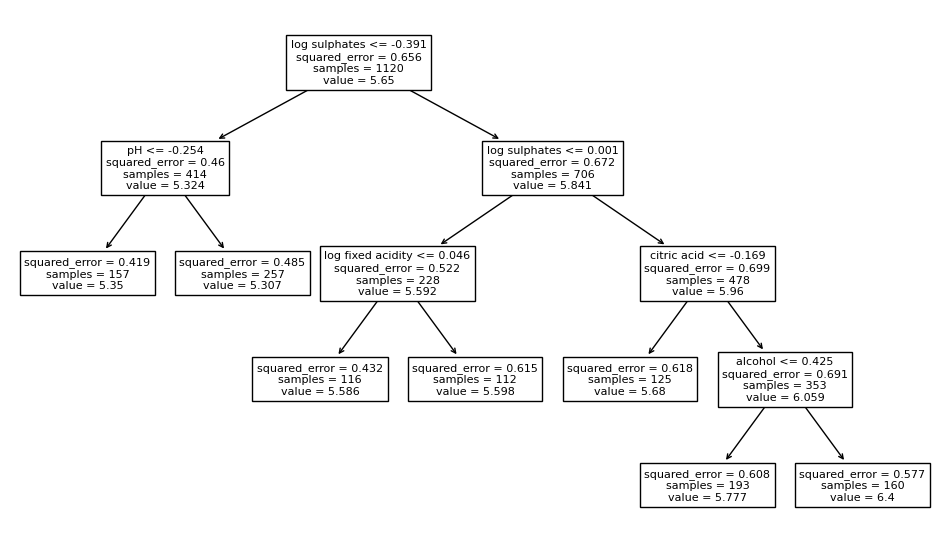

In [27]:
plt.figure(figsize = (12,7), dpi = 100)
tree.plot_tree(reg_decision_model,
               feature_names = X_treino.columns
               )
plt.show()

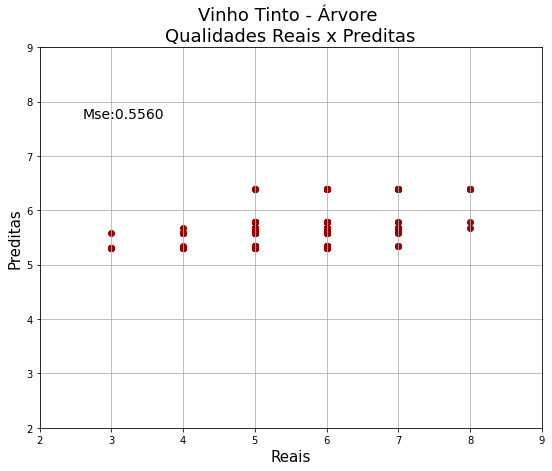

In [28]:
plt.figure(figsize=(9,7))

Y_predito = reg_decision_model.predict(X_teste)

plt.scatter(Y_teste, Y_predito, color='#990000')
plt.title('Vinho Tinto - Árvore \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_tree:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

## Vinho Branco

In [29]:
parameters={"splitter": hp.choice('splitter', ["random","best"]),
            "max_depth" : hp.uniform('max_depth',1,10),
            "min_samples_leaf": hp.uniform('min_samples_leaf',0,0.5),
            "min_weight_fraction_leaf": hp.choice('min_weight_fraction_leaf',
                                                  [0.1,0.2,0.3,0.4,0.5]),
            "max_features": hp.choice('max_features', ["auto","log2",None]),
            "max_leaf_nodes": hp.choice('max_leaf_nodes', [None,10,20,30])
}

def hyperparameter_tuning(space):
  
  model= DecisionTreeRegressor(splitter= space['splitter'],
                  min_weight_fraction_leaf= space['min_weight_fraction_leaf'],
                  max_depth= space['max_depth'],
                  min_samples_leaf= space['min_samples_leaf'],
                  max_features= space['max_features'],
                  max_leaf_nodes= space['max_leaf_nodes']
  )

  evaluation = [( X_treino_w, Y_treino_w), ( X_teste_w, Y_teste_w)]

  model.fit(X_treino_w, Y_treino_w)

  pred= model.predict(X_teste_w)
  mse= mean_squared_error(Y_teste_w, pred)
  #print("SCORE:", mse)
  return {'loss':mse, 'status': STATUS_OK, 'model': model}



trials = Trials()
best_w = fmin(fn=hyperparameter_tuning,
              space=parameters,
              algo=tpe.suggest,
              max_evals=500,
              trials=trials)

print(best_w)

100%|██████████| 500/500 [00:12<00:00, 38.96it/s, best loss: 0.5200208346436407]
{'max_depth': 3.3368940898417563, 'max_features': 0, 'max_leaf_nodes': 3, 'min_samples_leaf': 0.15242113045881567, 'min_weight_fraction_leaf': 0, 'splitter': 1}


In [30]:
reg_dec_model_w=DecisionTreeRegressor(max_depth= 3, min_samples_leaf= 0.154,
                                      max_features='log2', max_leaf_nodes=10,
                                      min_weight_fraction_leaf= 0.1,
                                      splitter = 'best')

reg_dec_model_w.fit(X_treino_w, Y_treino_w)

DecisionTreeRegressor(max_depth=3, max_features='log2', max_leaf_nodes=10,
                      min_samples_leaf=0.154, min_weight_fraction_leaf=0.1)

In [31]:
mse_tree_w = np.mean(cross_val_score(reg_dec_model_w, X_teste_w, Y_teste_w,
                                     cv=10, scoring='neg_mean_squared_error'))
print(-mse_tree_w)

0.583552847536814


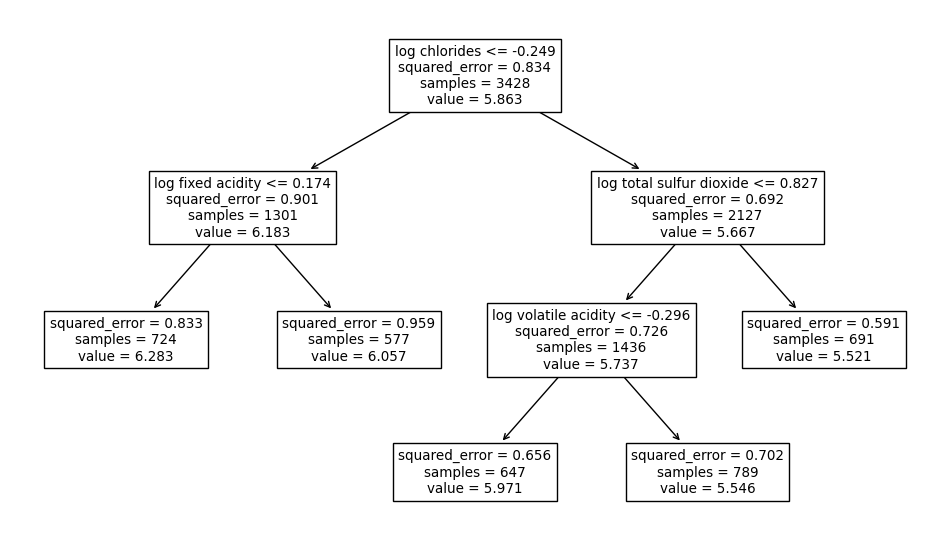

In [32]:
plt.figure(figsize = (12,7), dpi = 100)
tree.plot_tree(reg_dec_model_w,
               feature_names = X_treino_w.columns
)
plt.show()

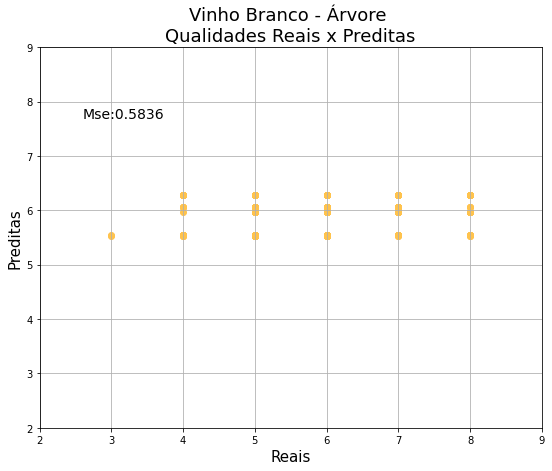

In [33]:
plt.figure(figsize=(9,7))

Y_pred_w = reg_dec_model_w.predict(X_teste_w)

plt.scatter(Y_teste_w, Y_pred_w, color='#ffc34d')
plt.title('Vinho Branco - Árvore \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_tree_w:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

# Random Forest

## Vinho Tinto

In [34]:
space = {'n_estimators': hp.choice('n_estimators', [100,200,300,400,500]),
         'max_features': hp.uniform('max_features', 1,5),
         'oob_score' : hp.choice('oob_score', [True, False])
}


def hyperparameter_tuning(space):
  
  model=RandomForestRegressor(n_estimators= int(space['n_estimators']),
                              max_features= int(space['max_features']),
                              oob_score=space['oob_score']
  )

  evaluation = [( X_treino, Y_treino), ( X_teste, Y_teste)]

  model.fit(X_treino, Y_treino)

  pred= model.predict(X_teste)
  mse= mean_squared_error(Y_teste, pred)
  #print("SCORE:", mse)
  
  return {'loss':mse, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

100%|██████████| 100/100 [01:16<00:00,  1.31it/s, best loss: 0.42215615866388306]
{'max_features': 3.48357259363309, 'n_estimators': 0, 'oob_score': 1}


In [35]:
tuned_regr = RandomForestRegressor(max_features = 4,
                                   n_estimators = 200,
                                   bootstrap = True,
                                   oob_score = False)

tuned_regr.fit(X_treino, Y_treino)

RandomForestRegressor(max_features=4, n_estimators=200)

In [36]:
mse_forest = np.mean(cross_val_score(tuned_regr, X_teste, Y_teste, cv= 10,
                                     scoring= 'neg_mean_squared_error'))

print(-mse_forest)

0.4248160649379433


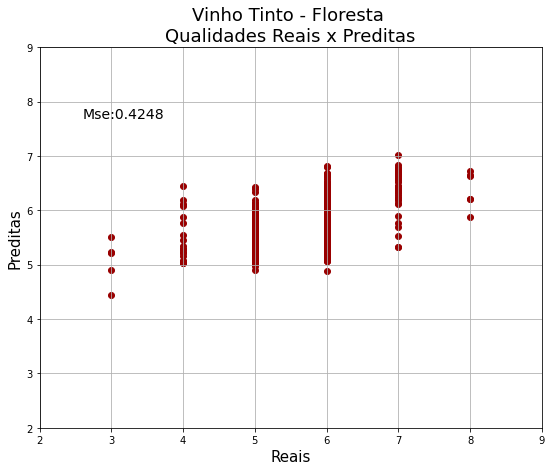

In [37]:
plt.figure(figsize=(9,7))

Y_predito = tuned_regr.predict(X_teste)

plt.scatter(Y_teste, Y_predito, color='#990000')
plt.title('Vinho Tinto - Floresta \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_forest:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start= 200, stop= 2000, num= 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num= 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#regr = RandomForestRegressor()

#rf_random = RandomizedSearchCV(estimator= regr,
#                               param_distributions= random_grid,
#                               n_iter= 50, cv= 3, verbose= 2,
#                               random_state= 42, n_jobs= -1)

#rf_random.fit(X_treino, Y_treino)

In [39]:
#rf_random.best_params_
#regr.feature_importances_

In [40]:

#tuned_regr = RandomForestRegressor(bootstrap= True, max_depth= 10,
#                                   max_features= 'sqrt', min_samples_leaf= 1,
#                                   min_samples_split= 5, n_estimators= 2000)

#tuned_regr.fit(X_treino, Y_treino)

In [41]:
#mse_forest = np.mean(cross_val_score(tuned_regr, X_teste, Y_teste, cv= 10,
#                                     scoring= 'neg_mean_squared_error'))

#print(-mse_forest)

In [42]:
X_teste.columns

Index(['log fixed acidity', 'log volatile acidity', 'citric acid',
       'log residual sugar', 'log chlorides', 'log free sulfur dioxide',
       'log total sulfur dioxide', 'log density', 'pH', 'log sulphates',
       'alcohol'],
      dtype='object')

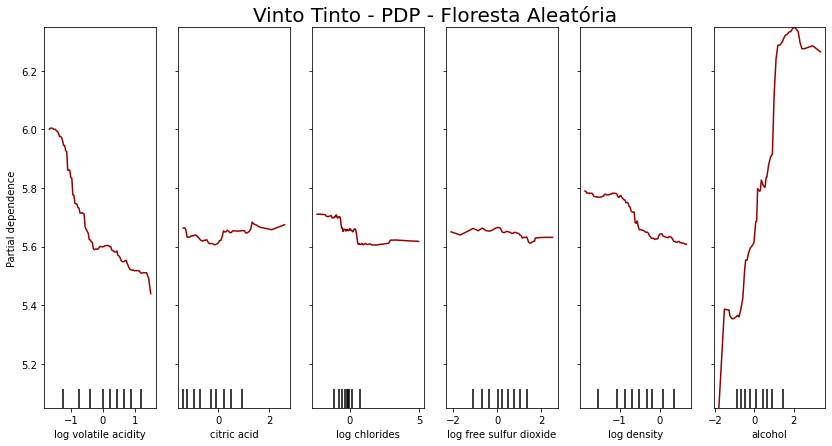

In [43]:
from sklearn.inspection import PartialDependenceDisplay

# PDP de todas as variáveis:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("Vinto Tinto - PDP - Floresta Aleatória", fontsize=20)
tinto_pdp=PartialDependenceDisplay.from_estimator(tuned_regr, X_teste,
                                                  ['log volatile acidity', 'citric acid', 'log chlorides', 'log free sulfur dioxide', 'log density', 'alcohol'], ax=ax,
                                                  line_kw={"color":"#990000"},
                                                  n_cols=6, n_jobs=-1)

Quanto menos inclinação, menos a variável é relevante. Ou seja, apenas `log volatile acidity`, `log total sulfur dioxide`, `log sulphates` e `alcohol` são importantes para o modelo. Talvez o `pH` e a `log density` também sejam, mas muito pouco.

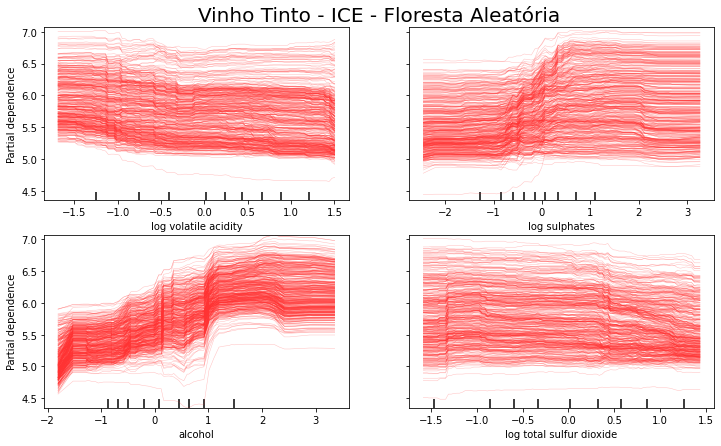

In [44]:
# ICE das variáveis relevantes:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("Vinho Tinto - ICE - Floresta Aleatória", fontsize=20)
tinto_ice=PartialDependenceDisplay.from_estimator(tuned_regr, X_teste,
                                   ['log volatile acidity', 'log sulphates',
                                    'alcohol', 'log total sulfur dioxide'],
                                   ax=ax, line_kw={"color":"#ff3333"},
                                   n_cols=2, kind='individual', n_jobs=-1)

Este gráfico por sua vez tenta verificar a influência de outras covariáveis na relevância da covariável  em  questão. No caso, a tendência se mantém em todos, ou seja, há pouco interação entre as covariáveis escolhidas e todas as outras.

## Vinho Branco

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {'n_estimators': hp.choice('n_estimators', [100,200,300,400,500]),
         'max_features': hp.uniform('max_features', 1,5),
         'oob_score' : hp.choice('oob_score', [True, False])
}


def hyperparameter_tuning(space):
  
  model=RandomForestRegressor(n_estimators= int(space['n_estimators']),
                              max_features= int(space['max_features'])
  )

  evaluation = [( X_treino_w, Y_treino_w), ( X_teste_w, Y_teste_w)]

  model.fit(X_treino_w, Y_treino_w)

  pred_w= model.predict(X_teste_w)
  mse= mean_squared_error(Y_teste_w, pred_w)
  #print("SCORE:", mse)
  
  return {'loss':mse, 'status': STATUS_OK, 'model': model}


trials = Trials()
best_w = fmin(fn=hyperparameter_tuning,
              space=space,
              algo=tpe.suggest,
              max_evals=100,
              trials=trials)

print(best_w)

100%|██████████| 100/100 [03:32<00:00,  2.12s/it, best loss: 0.4398684816326531]
{'max_features': 2.636227460255199, 'n_estimators': 4, 'oob_score': 0}


In [46]:
tuned_regr_w = RandomForestRegressor(max_features = 2,
                                     n_estimators = 300,
                                     bootstrap = True,
                                     oob_score = False)

tuned_regr_w.fit(X_treino_w, Y_treino_w)

RandomForestRegressor(max_features=2, n_estimators=300)

In [47]:
from sklearn.model_selection import cross_val_score

mse_forest_w = np.mean(cross_val_score(tuned_regr_w, X_teste_w, Y_teste_w,
                                       cv=10, scoring='neg_mean_squared_error'))

print(-mse_forest_w)

0.3912004761904762


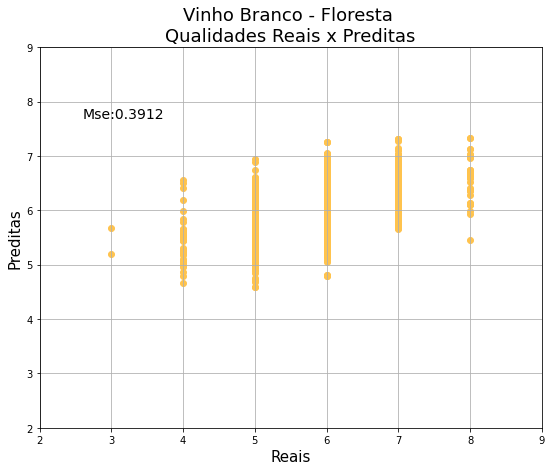

In [48]:
plt.figure(figsize=(9,7))

Y_pred_w = tuned_regr_w.predict(X_teste_w)

plt.scatter(Y_teste_w, Y_pred_w, color='#ffc34d')
plt.title('Vinho Branco - Floresta \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_forest_w:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

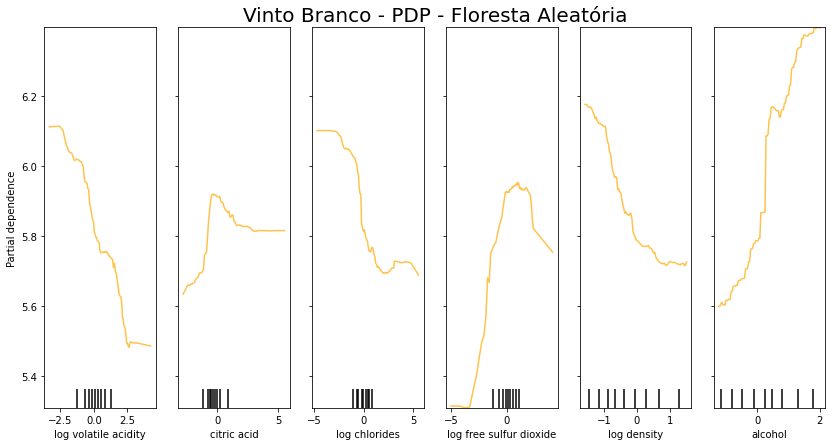

In [49]:
from sklearn.inspection import PartialDependenceDisplay

# PDP de todas as variáveis:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title("Vinto Branco - PDP - Floresta Aleatória", fontsize=20)
branco_pdp=PartialDependenceDisplay.from_estimator(tuned_regr_w, X_teste_w,
                                                  ['log volatile acidity', 'citric acid', 'log chlorides', 'log free sulfur dioxide', 'log density', 'alcohol'],
                                                   line_kw={"color":"#ffc34d"},
                                                   ax=ax, n_cols=6, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   27.4s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   40.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   40.4s finished


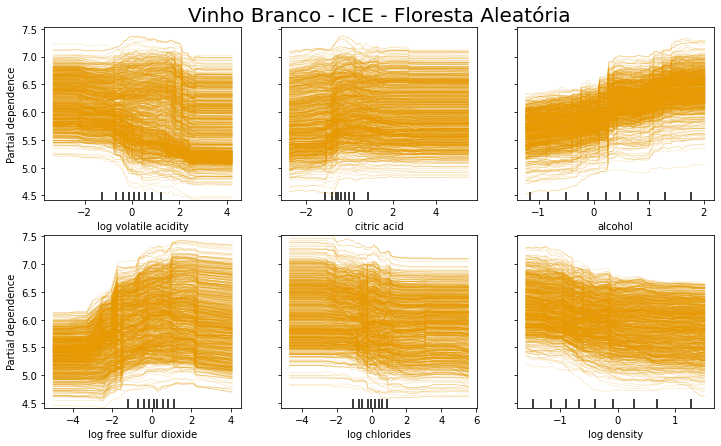

In [50]:
# ICE das variáveis relevantes:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("Vinho Branco - ICE - Floresta Aleatória", fontsize=20)
branco_ice=PartialDependenceDisplay.from_estimator(tuned_regr_w, X_teste_w,
                                    ['log volatile acidity', 'citric acid',
                                     'alcohol', 'log free sulfur dioxide',
                                     'log chlorides', 'log density'],
                                    ax=ax,line_kw={"color":"#e69900"},n_cols=3,
                                    kind='individual', n_jobs=-1, verbose=1000)

# XGBoost

## Vinho Tinto

In [51]:

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
       'subsample' : hp.uniform('subsample',0.2,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
       'learning_rate': hp.quniform('learning_rate',0,0.1, 0.001),
       'seed': 42
}

def hyperparameter_tuning(space):
  
  model=xgb.XGBRegressor(n_estimators= space['n_estimators'],
                         max_depth= int(space['max_depth']),
                         reg_alpha= int(space['reg_alpha']),
                         gamma= space['gamma'], objective="reg:squarederror",
                         min_child_weight= int(space['min_child_weight']),
                         learning_rate= space['learning_rate'],
                         colsample_bytree= int(space['colsample_bytree']),
                         subsample = space['subsample'])

  evaluation = [( X_treino, Y_treino), ( X_teste, Y_teste)]

  model.fit(X_treino, Y_treino,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

  pred= model.predict(X_teste)
  mse= mean_squared_error(Y_teste, pred)
  #print("SCORE:", mse)
  return {'loss':mse, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

100%|██████████| 100/100 [00:51<00:00,  1.94it/s, best loss: 0.4839637195180635]
{'colsample_bytree': 0.45922330641071657, 'gamma': 5.091744426532049, 'learning_rate': 0.039, 'max_depth': 9.0, 'min_child_weight': 7.0, 'n_estimators': 5, 'reg_alpha': 40.0, 'reg_lambda': 0.8397690541921359, 'subsample': 0.9002074956123158}


In [52]:
# model=xgb.XGBRegressor(colsample_bytree = 0.6144240905252741,
#                        gamma = 2.560337955657938, max_depth = 11,
#                        min_child_weight = 4, reg_alpha = 103,
#                        reg_lambda = 0.3213361978457983)

est = [100,200,300,400,500,600,700,800,900,1000]
model=xgb.XGBRegressor(colsample_bytree = int(best['colsample_bytree']),
                       gamma = best['gamma'], objective="reg:squarederror",
                       max_depth = int(best['max_depth']),
                       min_child_weight = int(best['min_child_weight']),
                       reg_alpha = int(best['reg_alpha']),
                       learning_rate = best['learning_rate'],
                       n_estimators = est[best['n_estimators']],
                       reg_lambda = int(best['reg_lambda'])
)

evaluation = [( X_treino, Y_treino), ( X_teste, Y_teste)]

model.fit(X_treino, Y_treino, eval_set=evaluation,
          eval_metric="rmse", verbose=False,
          early_stopping_rounds=10)

XGBRegressor(colsample_bytree=0, gamma=5.091744426532049, learning_rate=0.039,
             max_depth=9, min_child_weight=7, n_estimators=600,
             objective='reg:squarederror', reg_alpha=40, reg_lambda=0)

In [53]:
mse_xgb= np.mean(cross_val_score(model, X_teste, Y_teste, cv= 10,
                                 scoring= 'neg_mean_squared_error'))

print(-mse_xgb)

0.5727752117097383


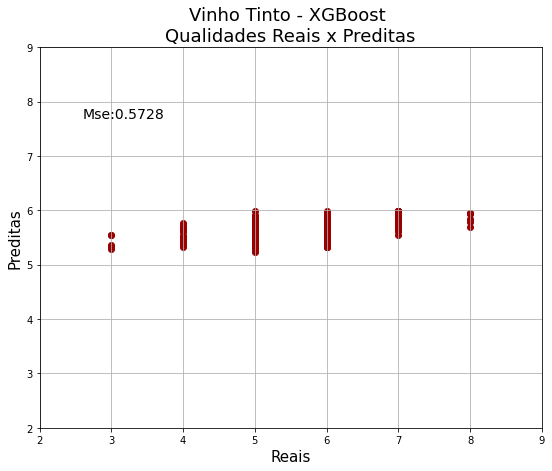

In [54]:
plt.figure(figsize=(9,7))

Y_predito = model.predict(X_teste)

plt.scatter(Y_teste, Y_predito, color='#990000')
plt.title('Vinho Tinto - XGBoost \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_xgb:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

## Vinho Branco

In [55]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
       'subsample' : hp.uniform('subsample',0.2,1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice('n_estimators', [100,200,300,400,500,600,700,800,900,1000]),
       'learning_rate': hp.quniform('learning_rate',0,0.1, 0.001),
       'seed': 42
}


def hyperparameter_tuning(space):
  
  model=xgb.XGBRegressor(n_estimators= space['n_estimators'],
                         max_depth= int(space['max_depth']),
                         reg_alpha= int(space['reg_alpha']),
                         gamma= space['gamma'], objective="reg:squarederror",
                         min_child_weight= int(space['min_child_weight']),
                         learning_rate = space['learning_rate'],
                         subsample= space['subsample'],
                         colsample_bytree= int(space['colsample_bytree']))

  evaluation = [( X_treino_w, Y_treino_w), ( X_teste_w, Y_teste_w)]

  model.fit(X_treino_w, Y_treino_w,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

  pred_w= model.predict(X_teste_w)
  mse= mean_squared_error(Y_teste_w, pred_w)
  #print("SCORE:", mse)
  return {'loss':mse, 'status': STATUS_OK, 'model': model}


trials = Trials()
best_w = fmin(fn=hyperparameter_tuning,
              space=space,
              algo=tpe.suggest,
              max_evals=100,
              trials=trials)

print(best_w)

100%|██████████| 100/100 [01:50<00:00,  1.10s/it, best loss: 0.4782448585805266]
{'colsample_bytree': 0.8701350985095297, 'gamma': 1.3438519096442074, 'learning_rate': 0.035, 'max_depth': 5.0, 'min_child_weight': 3.0, 'n_estimators': 9, 'reg_alpha': 45.0, 'reg_lambda': 0.4892585015978427, 'subsample': 0.9029528075479495}


In [56]:
est = [100,200,300,400,500,600,700,800,900,1000]

model_w= xgb.XGBRegressor(colsample_bytree = int(best_w['colsample_bytree']),
                          gamma = best_w['gamma'], objective="reg:squarederror",
                          max_depth = int(best_w['max_depth']),
                          min_child_weight = int(best_w['min_child_weight']),
                          reg_alpha = int(best_w['reg_alpha']),
                          n_estimators = est[best['n_estimators']],
                          learning_rate = best['learning_rate'],
                          reg_lambda = int(best_w['reg_lambda'])
)

eval_w = [( X_treino_w, Y_treino_w), ( X_teste_w, Y_teste_w)]

model_w.fit(X_treino_w, Y_treino_w, eval_set=eval_w,
            eval_metric="rmse", verbose=False,
            early_stopping_rounds=10)

XGBRegressor(colsample_bytree=0, gamma=1.3438519096442074, learning_rate=0.039,
             max_depth=5, min_child_weight=3, n_estimators=600,
             objective='reg:squarederror', reg_alpha=45, reg_lambda=0)

In [57]:
mse_xgb_w= np.mean(cross_val_score(model_w, X_teste_w, Y_teste_w, cv= 10,
                                   scoring= 'neg_mean_squared_error'))

print(-mse_xgb_w)

0.49545182699665463


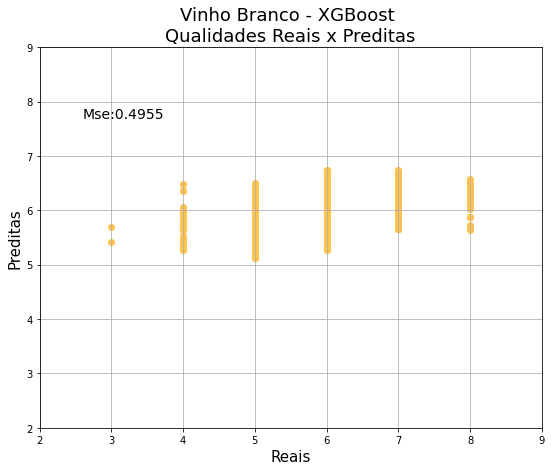

In [58]:
plt.figure(figsize=(9,7))

Y_pred_w = model_w.predict(X_teste_w)

plt.scatter(Y_teste_w, Y_pred_w, color='#ffc34d')
plt.title('Vinho Branco - XGBoost \nQualidades Reais x Preditas',
          fontsize=18)
plt.xlabel('Reais', fontsize=15)
plt.ylabel('Preditas', fontsize=15)
plt.xticks(np.arange(2,10))
plt.yticks(np.arange(2,10))
plt.annotate(f'Mse:{-1*mse_xgb_w:.4f}', xy=(2.6,7.7), fontsize=14)
plt.grid(True)
plt.show()

#Bibliografia


- **Fixed Acidity** - https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity
- **Database** - https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009
- **Refpaper** - https://reader.elsevier.com/reader/sd/pii/S0167923609001377?token=ED175ABE9BAE061960A95120FC3A32A315241073D060C3BBDA40F69ABFB2A8EEEF274842BBA0780C724354E8410958BA&originRegion=us-east-1&originCreation=20220522150509
- **Refcod** - https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

- **HyperOPT** - Alternative for HyperParameter Tuning - https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook


https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9